In [7]:
import cv2
from matplotlib import pyplot as plt
from ipywidgets import interact_manual, interact
import numpy as np


In [80]:
!pip install opencv-contrib-python

  Using cached https://files.pythonhosted.org/packages/00/ee/94d11d1debd8b3fe46479e7b9479006432de14576714f9b5c4d2a72a14c5/opencv_contrib_python-4.1.1.26-cp37-cp37m-macosx_10_8_x86_64.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


True

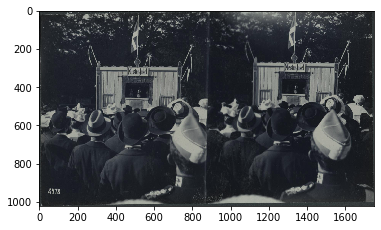

In [3]:
def get_contours(img):
    """Threshold the image and get contours."""
    # First make the image 1-bit and get contours
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the right threshold level
    tl = 5
    ret, thresh = cv2.threshold(imgray, tl, 255, 0)
    while white_percent(thresh) > 0.60:
        tl += 10
        ret, thresh = cv2.threshold(imgray, tl, 255, 0)

    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    # filter contours that are too large or small
    contours = [cc for cc in contours if contourOK(img, cc)]
    return contours
    
def get_size(img):
    """Return the size of the image in pixels."""
    ih, iw = img.shape[:2]
    return iw * ih

def white_percent(img):
    """Return the percentage of the thresholded image that's white."""
    return cv2.countNonZero(img) / get_size(img)

def contourOK(img, cc):
    """Check if the contour is a good predictor of photo location."""
    if near_edge(img, cc): return False # shouldn't be near edges
    x, y, w, h = cv2.boundingRect(cc)
    if w < 100 or h < 100: return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    if area > (get_size(img) * 0.3): return False
    if area < 200: return False
    return True

def near_edge(img, contour):
    """Check if a contour is near the edge in the given image."""
    x, y, w, h = cv2.boundingRect(contour)
    ih, iw = img.shape[:2]
    mm = 20 # margin in pixels
    return (x < mm
            or x + w > iw - mm
            or y < mm
            or y + h > ih - mm)   

def get_boundaries(img, contours):
    """Find the boundaries of the photo in the image using contours."""
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape[:2]
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h


    return (minx, miny, maxx, maxy)

def crop(img, boundaries):
    """Crop the image to the given boundaries."""
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]

image = cv2.imread('stereo.jpg')
contours = get_contours(image)
bounds = get_boundaries(image, contours)
cropped = crop(image, bounds)

plt.imshow(cropped) 
cv2.imwrite('cropped.jpg', cropped)


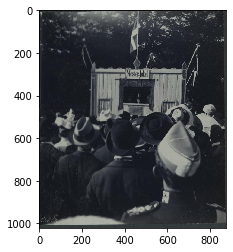

In [62]:
height, width, _ = cropped.shape
half_width = int(width/2)
plt.imshow(cropped[0:, half_width:])

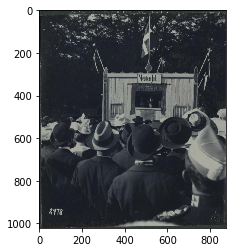

In [63]:
plt.imshow(cropped[0:, :half_width])

In [9]:
@interact
def foo(sigma=1.4, lmbda=80000, window_size_val=15):
    height, width, _ = cropped.shape
    half_width = int(width/2)
    imgL = cropped[0:, :half_width]
    imgR = cropped[0:, half_width:]

    window_size = window_size_val                   # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely

    left_matcher = cv2.StereoSGBM_create(
        minDisparity = 0,
        numDisparities = 1 * 16,             # max_disp has to be dividable by 16 f. E. HH 192, 256
        blockSize = 1,
        P1=8 * 3 * window_size ** 2,    # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=1,
        speckleWindowSize=1,
        speckleRange=0,
        preFilterCap=2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    #This leads us to define the right_matcher so we can use it for our filtering later. This is a simple one-liner:

    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    #To obtain hole free depth-images we can use the WLS-Filter. This filter also requires some parameters which are shown below:

    # FILTER Parameters
    #lmbda = 80000
    #sigma = 1.4
    visual_multiplier = 1.0

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)
    #Now we can compute the disparities and convert the resulting images to the desired int16 format or how OpenCV names it: CV_16S for our filter:

    print('computing disparity...')
    displ = left_matcher.compute(imgL, imgR)  # .astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!
    #Finally if you show this image with imshow() you may not see anything. This is due to values being not normalized to a 8-bit format. So lets fix this by normalizing our depth map:

    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    filteredImg = np.uint8(filteredImg)

    plt.imshow(filteredImg) 
    cv2.imwrite(r'depth_out.png', filteredImg)



interactive(children=(FloatSlider(value=1.4, description='sigma', max=4.199999999999999, min=-1.4), IntSlider(…

In [10]:
cv2.imwrite(r'left.png', imgL)


True